In [24]:
import pandas as pd
import numpy as np
import yfinance as yf

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')

# 提取收盤價
X = data[['Open','High','Low','Volume']].values    # 多個輸入特徵
y = data[['Close']].values                         # 預測目標

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/3863106270.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
[*********************100%***********************]  1 of 1 completed


In [25]:
data[['Close','High','Low','Open','Volume']]

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261047,24.729270,23.821672,24.718174,212818400
2015-01-05,23.577570,24.110146,23.391169,24.030260,257142000
2015-01-06,23.579792,23.839422,23.218083,23.641926,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829126,24.886823,24.121244,24.238856,237458000
...,...,...,...,...,...
2020-12-24,128.591034,130.042889,127.743314,127.957683,54930100
2020-12-28,133.190216,133.823568,130.091628,130.559349,124486200


In [26]:
from sklearn.preprocessing import MinMaxScaler

# 目標是 單一特徵 (Close)，建議一開始就用 兩個 scaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [27]:
# 把時間序列切成 (seq_len, feature) 的小片段
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])     # shape: (seq_len, feature)
        y_seq.append(y[i+seq_len])       # shape: (1,)
    return np.array(X_seq), np.array(y_seq)

seq_len = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

print("X_seq:", X_seq.shape)  # (N, seq_len, feature_size)
print("y_seq:", y_seq.shape)  # (N, 1)
# X, y = create_sequences(dataset, lookback)

X_seq: (1487, 24, 4)
y_seq: (1487, 1)


In [28]:
import torch

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# train/test split
train_size = int(len(X_tensor) * 0.8)
X_train_tensor, X_test_tensor = X_tensor[:train_size], X_tensor[train_size:]
y_train_tensor, y_test_tensor = y_tensor[:train_size], y_tensor[train_size:]

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [29]:
# # 劃分比例
# train_size = int(len(X_seq) * 0.8)
# test_size = len(X_seq) - train_size

# X_train = X_seq[:train_size]
# y_train = y_seq[:train_size]
# X_test = X_seq[train_size:]
# y_test = y_seq[train_size:]

In [30]:
# # 將數據轉換為 PyTorch 張量
# import torch

# X_train_tensor = torch.from_numpy(X_train).float()
# y_train_tensor = torch.from_numpy(y_train).float()
# X_test_tensor = torch.from_numpy(X_test).float()
# y_test_tensor = torch.from_numpy(y_test).float()

In [31]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cpu


In [32]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, batch_first=False):
        super(PositionalEncoding, self).__init__()
        self.batch_first = batch_first

        # 建立位置編碼矩陣 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數維
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數維

        # 如果 batch_first=False → (max_len, 1, d_model)
        # 如果 batch_first=True → (1, max_len, d_model)
        if batch_first:
            pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        else:
            pe = pe.unsqueeze(1)  # (max_len, 1, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        if self.batch_first:
            # x shape: (batch, seq_len, d_model)
            x = x + self.pe[:, :x.size(1), :]
        else:
            # x shape: (seq_len, batch, d_model)
            x = x + self.pe[:x.size(0), :]
        return x

In [33]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1, batch_first=True):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim, batch_first=batch_first)  # 要確認 PositionalEncoding 也支援 batch_first
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, 
            dropout=dropout, batch_first=True  # 👈 加這個
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src 形狀: (batch_size, seq_length, feature_size)
        src = self.input_linear(src)
        src = self.pos_encoder(src)  # 也要改成支援 batch_first
        output = self.transformer_encoder(src)
        # 取最後一個時間步的輸出
        output = self.decoder(output[:, -1, :])  # 👈 改成 batch 在第一維
        return output


In [34]:
feature_size = X_train_tensor.size(-1)  # 輸入特徵數
print("feature_size:", feature_size)
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim, batch_first=True).to(device)

feature_size: 4


In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
# X_train_tensor = X_train_tensor.to(device)
# y_train_tensor = y_train_tensor.to(device)
# X_test_tensor = X_test_tensor.to(device)
# y_test_tensor = y_test_tensor.to(device)

In [37]:
# num_epochs = 100
# batch_size = X_train_tensor.size(1)

# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     output = model(X_train_tensor)
#     loss = criterion(output.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         model.eval()
#         with torch.no_grad():
#             test_output = model(X_test_tensor)
#             test_loss = criterion(test_output.squeeze(), y_test_tensor)
#         print(f'Epoch [{epoch + 1}/{num_epochs}], 訓練集 Loss: {loss.item():.4f}, 測試集 Loss: {test_loss.item():.4f}')

In [38]:
import torch
import torch.nn as nn

# 假設你已經有這些物件：
# model, criterion, optimizer
# X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

num_epochs = 50
batch_size = 32 # 通常是16、32或 64

# 建立 DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    # ===== Training =====
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # X_batch shape: (batch, seq_len, feature)
        # y_batch shape: (batch, pred_len) or (batch, 1)
        output = model(X_batch)  # forward pass
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    # ===== Evaluation =====
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")


Epoch [1/50] | Train Loss: 0.143203 | Test Loss: 0.073091
Epoch [2/50] | Train Loss: 0.009035 | Test Loss: 0.012461
Epoch [3/50] | Train Loss: 0.005399 | Test Loss: 0.004435
Epoch [4/50] | Train Loss: 0.004535 | Test Loss: 0.008719
Epoch [5/50] | Train Loss: 0.003666 | Test Loss: 0.004350
Epoch [6/50] | Train Loss: 0.002970 | Test Loss: 0.007475
Epoch [7/50] | Train Loss: 0.002427 | Test Loss: 0.004404
Epoch [8/50] | Train Loss: 0.002035 | Test Loss: 0.005587
Epoch [9/50] | Train Loss: 0.001827 | Test Loss: 0.005864
Epoch [10/50] | Train Loss: 0.001583 | Test Loss: 0.003102
Epoch [11/50] | Train Loss: 0.001334 | Test Loss: 0.003730
Epoch [12/50] | Train Loss: 0.001215 | Test Loss: 0.002556
Epoch [13/50] | Train Loss: 0.001082 | Test Loss: 0.002231
Epoch [14/50] | Train Loss: 0.000985 | Test Loss: 0.002181
Epoch [15/50] | Train Loss: 0.001274 | Test Loss: 0.003276
Epoch [16/50] | Train Loss: 0.000882 | Test Loss: 0.003436
Epoch [17/50] | Train Loss: 0.000803 | Test Loss: 0.004934
Epoch 

In [39]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()
    y_test_pred = model(X_test_tensor).cpu().numpy()

# 反歸一化 (只針對 y)
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_train_actual = scaler_y.inverse_transform(y_train_tensor.cpu().numpy())

y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())


In [40]:
# model.eval()
# with torch.no_grad():
#     train_predict = model(X_train_tensor).cpu().numpy()
#     test_predict = model(X_test_tensor).cpu().numpy()

# # 反歸一化
# train_predict = scaler.inverse_transform(train_predict)
# y_train_actual = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
# test_predict = scaler.inverse_transform(test_predict)
# y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:31: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:31: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:31: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:31: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:31: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366

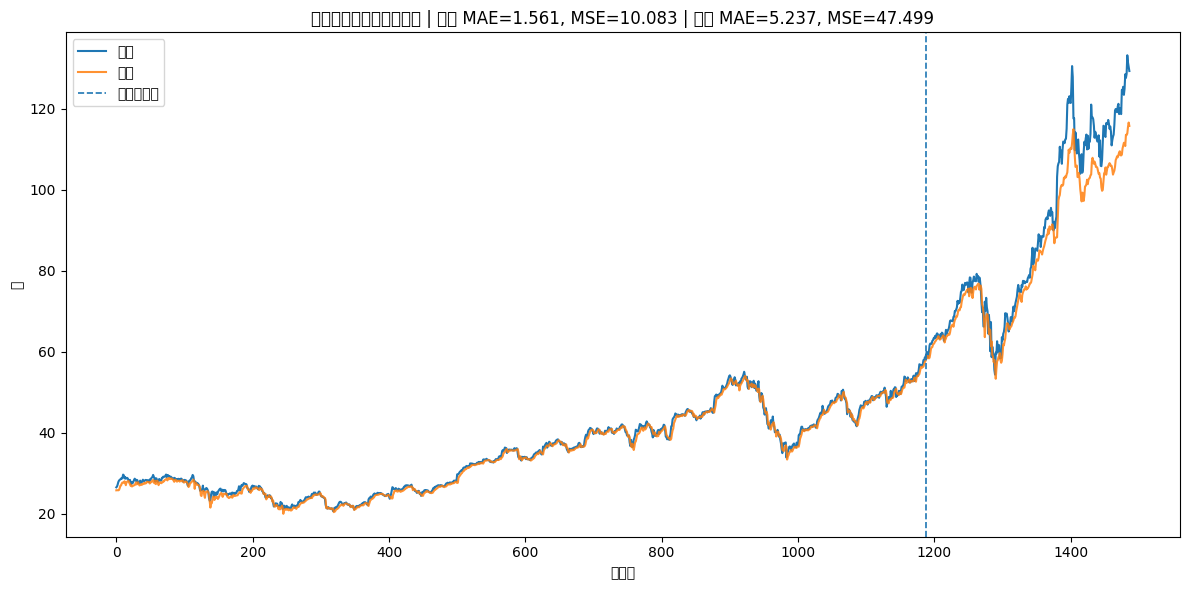

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:43: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:43: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:43: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:43: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_71361/1267780715.py:43: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366

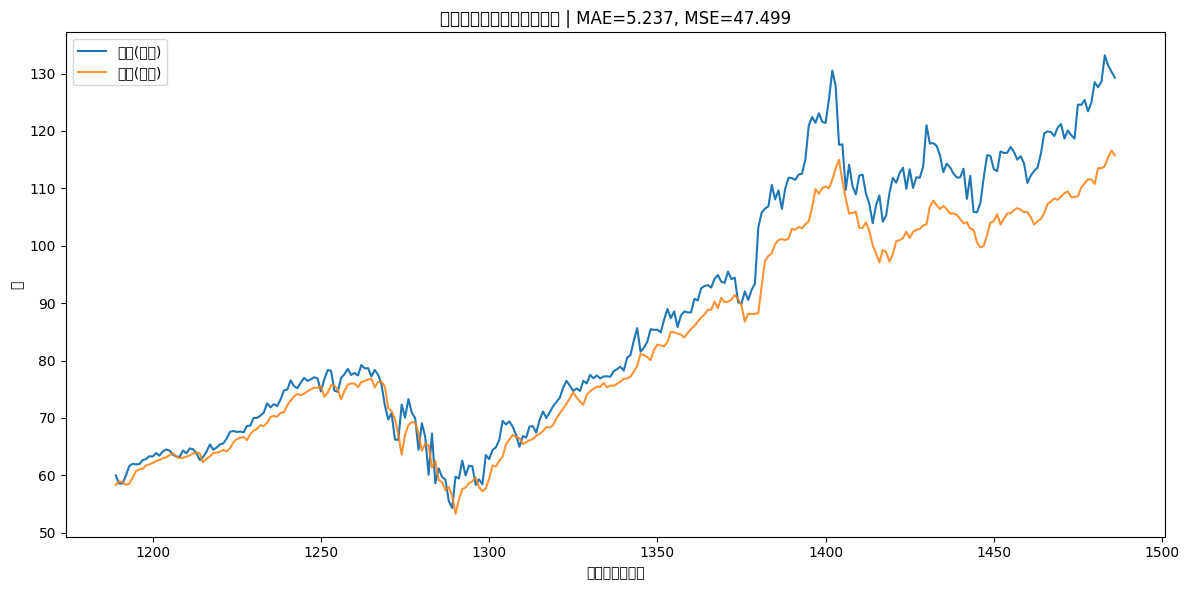

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) 拉平成一維
train_pred = y_train_pred_inv.squeeze()
test_pred  = y_test_pred_inv.squeeze()
train_act  = y_train_actual.squeeze()
test_act   = y_test_actual.squeeze()

# 2) 依「目標 y 的時間軸」拼接（注意：這裡的索引本來就對齊）
y_all_pred = np.concatenate([train_pred, test_pred], axis=0)
y_all_act  = np.concatenate([train_act,  test_act],  axis=0)
split_idx  = len(train_act)  # 測試集在整段中的起始位置

# 3) 評估指標（全段/測試段）
mae_all  = mean_absolute_error(y_all_act, y_all_pred)
mse_all = mean_squared_error(y_all_act, y_all_pred)
mae_test = mean_absolute_error(test_act, test_pred)
mse_test= mean_squared_error(test_act, test_pred)

# 4) 全區間圖（含訓練+測試）
plt.figure(figsize=(12,6))
plt.plot(y_all_act,  label='實際', linewidth=1.5)
plt.plot(y_all_pred, label='預測', alpha=0.85)
plt.axvline(split_idx-1, linestyle='--', linewidth=1.2, label='測試集開始')
plt.title(f'時間序列預測（全區間） | 全段 MAE={mae_all:.3f}, MSE={mse_all:.3f} | 測試 MAE={mae_test:.3f}, MSE={mse_test:.3f}')
plt.xlabel('時間步')
plt.ylabel('值')
plt.legend()
plt.tight_layout()
plt.show()

# 5) 測試集放大圖（更清楚看泛化）
plt.figure(figsize=(12,6))
x_test = np.arange(split_idx, len(y_all_act))
plt.plot(x_test, test_act,  label='實際(測試)', linewidth=1.5)
plt.plot(x_test, test_pred, label='預測(測試)', alpha=0.85)
plt.title(f'時間序列預測（測試區間） | MAE={mae_test:.3f}, MSE={mse_test:.3f}')
plt.xlabel('時間步（測試）')
plt.ylabel('值')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'訓練集 MSE: {train_score:.2f}')
print(f'測試集 MSE: {test_score:.2f}')

訓練集 MSE: 8.62
測試集 MSE: 818.03
